In [1]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

!pip install requests pandas matplotlib seaborn

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
import requests
from datetime import datetime
import matplotlib.font_manager as fm

# 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

 데이터 요청 성공!
    year           gdp
12  2010  1.143672e+12
11  2011  1.253290e+12
10  2012  1.278047e+12
9   2013  1.370633e+12
8   2014  1.484489e+12
7   2015  1.466039e+12
6   2016  1.499680e+12
5   2017  1.623074e+12
4   2018  1.725373e+12
3   2019  1.651423e+12
2   2020  1.644313e+12
1   2021  1.818432e+12
0   2022  1.673917e+12


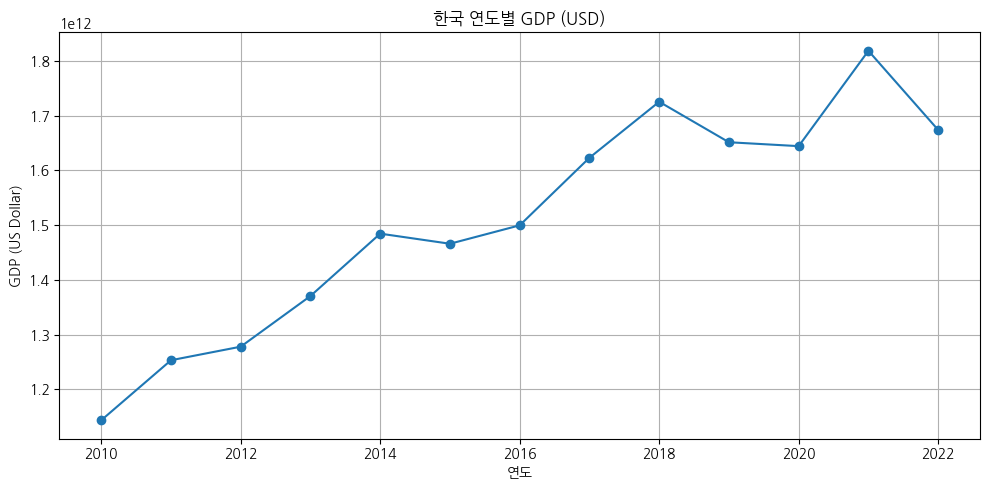

In [2]:
# 1. 한국(KOR)의 GDP 데이터를 요청할 API URL
# 2010년부터 2022년까지의 데이터 조회
url = "https://api.worldbank.org/v2/country/KOR/indicator/NY.GDP.MKTP.CD?format=json&date=2010:2022"

# 2. GET 요청
response = requests.get(url)

# 3. 응답 상태 확인
if response.status_code == 200:
    print(" 데이터 요청 성공!")
else:
    print(" 요청 실패:", response.status_code)

# 4. JSON 파싱
data = response.json()

# 5. 연도별 GDP 데이터 추출
gdp_data = []

for entry in data[1]:
    year = entry['date']
    value = entry['value']
    gdp_data.append({'year': int(year), 'gdp': value})

# 6. DataFrame으로 정리
df = pd.DataFrame(gdp_data)
df = df.sort_values('year')

# 7. 출력
print(df)

# 8. 시각화
plt.figure(figsize=(10,5))
plt.plot(df['year'], df['gdp'], marker='o')
plt.title("한국 연도별 GDP (USD)")
plt.xlabel("연도")
plt.ylabel("GDP (US Dollar)")
plt.grid(True)
plt.tight_layout()
plt.show()

# GDP 대비 교육/보건 지출

In [3]:
import requests
import pandas as pd
import plotly.express as px

In [4]:
#  API 요청 함수 정의
def get_world_bank_data(country_code, indicator, start_year, end_year):
    url = f"https://api.worldbank.org/v2/country/{country_code}/indicator/{indicator}?format=json&date={start_year}:{end_year}"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"❌ 요청 실패: {response.status_code}")
        return None
    return response.json()

# . 데이터 파싱 함수
def parse_data(json_data):
    result = []
    for entry in json_data[1]:
        year = int(entry['date'])
        value = entry['value']
        if value is not None:
            result.append({'year': year, 'value': value})
    return pd.DataFrame(result)

# 🇰🇷 5. 지표별 데이터 수집
# 교육 지출 (% of GDP)
edu_json = get_world_bank_data("KOR", "SE.XPD.TOTL.GD.ZS", 2010, 2022)
edu_df = parse_data(edu_json)
edu_df['indicator'] = '교육 지출'

# 보건 지출 (% of GDP)
health_json = get_world_bank_data("KOR", "SH.XPD.CHEX.GD.ZS", 2010, 2022)
health_df = parse_data(health_json)
health_df['indicator'] = '보건 지출'

#  데이터 병합
merged_df = pd.concat([edu_df, health_df])
merged_df = merged_df.sort_values(by='year')

# Plotly 인터랙티브 시각화
fig = px.line(
    merged_df,
    x='year',
    y='value',
    color='indicator',
    title='대한민국 GDP 대비 교육 및 보건 지출 비율 (2010~2022)',
    markers=True,
    labels={'value': '% of GDP', 'year': '연도', 'indicator': '지표'}
)

fig.update_layout(template='plotly_white', hovermode='x unified')
fig.show()

# OECD 국가 비교

In [5]:
import requests
import pandas as pd
import plotly.express as p

In [6]:
#  API 요청 함수
def get_world_bank_data(country_code, indicator, start_year, end_year):
    url = f"https://api.worldbank.org/v2/country/{country_code}/indicator/{indicator}?format=json&date={start_year}:{end_year}&per_page=500"
    response = requests.get(url)
    if response.status_code != 200:
        print(f" 요청 실패: {country_code}, 상태 코드: {response.status_code}")
        return None
    return response.json()

#  데이터 파싱 함수
def parse_data(json_data, country_code, indicator_name):
    result = []
    for entry in json_data[1]:
        year = int(entry['date'])
        value = entry['value']
        if value is not None:
            result.append({
                'year': year,
                'value': value,
                'country': country_code,
                'indicator': indicator_name
            })
    return pd.DataFrame(result)

#  OECD 국가 목록
oecd_countries = {
    'KOR': '한국',
    'USA': '미국',
    'JPN': '일본',
    'DEU': '독일',
    'FRA': '프랑스'
}

#  지표 코드
indicators = {
    'SE.XPD.TOTL.GD.ZS': '교육 지출',
    'SH.XPD.CHEX.GD.ZS': '보건 지출'
}

#  데이터 수집
all_data = []

for iso, kor_name in oecd_countries.items():
    for code, label in indicators.items():
        json_data = get_world_bank_data(iso, code, 2010, 2022)
        if json_data:
            df = parse_data(json_data, kor_name, label)
            all_data.append(df)

#  데이터 병합
final_df = pd.concat(all_data)
final_df = final_df.sort_values(['indicator', 'country', 'year'])

#  Plotly 시각화 (교육/보건 중 1개만 예시)
for indicator in final_df['indicator'].unique():
    fig = px.line(
        final_df[final_df['indicator'] == indicator],
        x='year',
        y='value',
        color='country',
        title=f"OECD 주요국 GDP 대비 {indicator} 비율 (2010~2022)",
        labels={'value': '% of GDP', 'year': '연도', 'country': '국가'},
        markers=True
    )
    fig.update_layout(template='plotly_white', hovermode='x unified')
    fig.show()